# Submitted Runs Evaluation

In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_json('/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/data-26-10-2020/rankings/original-runs-evaluation.jsonl', lines=True)

#### plot-web-2009-reproducibility-with-bpref from the paper

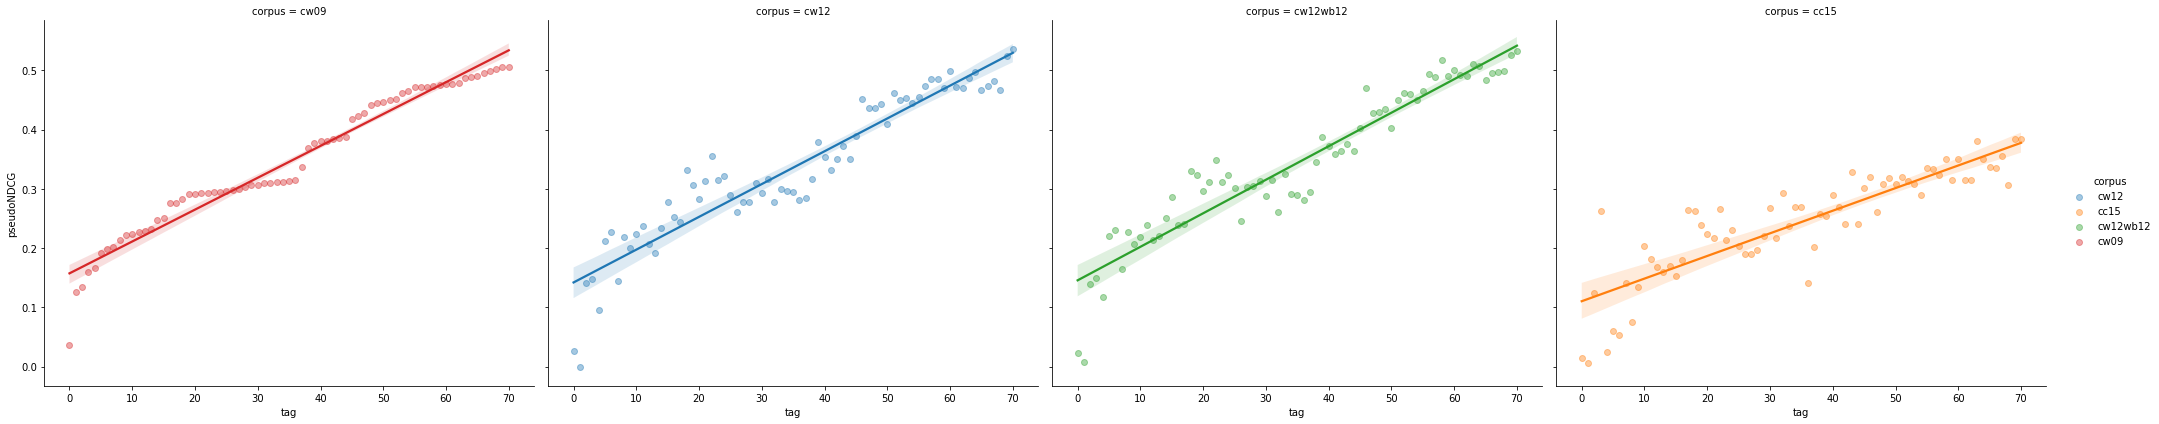

In [2]:
def plot_correlations_per_corpus(df, measure: str, topics):
    df = df[df['topics'] == topics]
    sorted_approaches = {k: v for v,k in enumerate(df[(df['corpus'] == 'cw09')].sort_values(measure).tag.unique())}
    df = df.loc[:,["corpus","tag",measure]].sort_values(measure).replace(sorted_approaches)
    
    g = sns.FacetGrid(
        df, 
        col="corpus",
        hue="corpus",
        col_order=['cw09', 'cw12', 'cw12wb12', 'cc15'],
        height=6,
        aspect=1.2
    )
    g.map(sns.regplot, "tag", measure, scatter_kws={'alpha':0.4})
    g.add_legend()
    
    return g


g = plot_correlations_per_corpus(df, 'pseudoNDCG', '1-50')
g.savefig('/sigir21/sigir21-relevance-label-transfer-figures/plot-web-2009-reproducibility-with-bpref.pdf', format='pdf')

#### table-track-reproducibility from the paper

In [3]:
def year_to_topic(year):
    if year == '2009':
        return '1-50'
    elif year == '2010':
        return '51-100'
    elif year == '2011':
        return '101-150'
    elif year == '2012':
        return '151-200'
    elif year == '2013':
        return '201-250'
    elif year == '2014':
        return '251-300'
    else:
        raise

def format_kendall_tau(i):
    if i >= 0:
        return '\\phantom{-}' + '{:.2f}'.format(i)
    else:
        return '{:.2f}'.format(i)

def correlation(df, year:str, target_corpus: str, from_measure: str, to_measure: str):
    df = df[df['topics'] == year_to_topic(year)].pivot("tag","corpus",["bpref","pseudoNDCG@10", "pseudoNDCG"]).corr(method="kendall")
    for k,v in df.iterrows(): 
        if k == (from_measure, 'cw09'):
            return format_kendall_tau(v[to_measure][target_corpus])

    raise

def top_5_systems(df, corpus: str, topics: str, measure: str):
    df = df[(df['corpus'] == corpus) & (df['topics'] == topics)]
    
    return [i for i in df.sort_values(measure, ascending=False)[0:5].tag]

def top_5_systems_df_for_cw09_and_target_corpus(df, target_corpus: str, topics: str, measure: str):
    systems = []
    systems += top_5_systems(df, 'cw09', topics, measure)
    systems += top_5_systems(df, target_corpus, topics, measure)
    
    return df[((df['corpus'] == target_corpus) | (df['corpus'] == 'cw09')) & (df['topics'] == topics) & (df['tag'].isin(systems))]

    
def ndcg_to_ndcg(df, year, target_corpus):
    return correlation(df, year, target_corpus, 'pseudoNDCG', 'pseudoNDCG')
    
def bpref_to_bpref(df, year, target_corpus):
    return correlation(df, year, target_corpus, 'bpref', 'bpref')

def ndcg_to_ndcg_5(df, year, target_corpus):
    df = top_5_systems_df_for_cw09_and_target_corpus(df, target_corpus, year_to_topic(year), 'bpref')
    return correlation(df, year, target_corpus, 'pseudoNDCG', 'pseudoNDCG')

def row_table_track_reproducivility(df, year:str):
    if year in ['2009', '2010', '2011', '2012']:
        return '& ' + year + ' & ' + \
            bpref_to_bpref(df, year,'cw12') + ' & ' + bpref_to_bpref(df, year,'cw12wb12') + ' & ' + bpref_to_bpref(df, year,'cc15') + ' & ' + \
            ndcg_to_ndcg(df, year,'cw12') + ' & ' + ndcg_to_ndcg(df, year,'cw12wb12') + ' & ' + ndcg_to_ndcg(df, year,'cc15') + ' & ' + \
            ndcg_to_ndcg_5(df, year,'cw12') + ' & ' + ndcg_to_ndcg_5(df, year,'cw12wb12') + ' & ' + ndcg_to_ndcg_5(df, year,'cc15') + ' \\\\\n'
    else:
        return '& ' + year + ' & - & - & ' + \
            bpref_to_bpref(df, year,'cc15') + ' & - & - & ' + \
            ndcg_to_ndcg(df, year,'cc15') + ' & - & - & ' + \
            ndcg_to_ndcg_5(df, year,'cc15') + ' \\\\\n'

def create_table_track_reproducibility(df):
    return """
\\begin{table}[tb]
\\caption{TBD.}

(a) TBD: Web
\\label{table-track-reproducibility}
\\small
\\centering
\\setlength{\\tabcolsep}{12pt}
\\begin{tabular}{@{}c@{}c@{\\hspace{1em}}c@{\\ \\ }c@{\\ \\ }c@{\\ \\ }c@{\\ \\ }c@{\\ \\ }c@{\\ \\ }c@{\\ \\ }c@{\\ \\ }c@{}}
\\toprule
\\multicolumn{2}{@{}l@{}}{\\bfseries Track} & \\multicolumn{3}{@{}c@{\\hspace{1em}}}{\\bfseries $\\boldsymbol{\\tau}$ (bpref)} & \\multicolumn{3}{@{}c@{\\hspace{1em}}}{\\bfseries $\\boldsymbol{\\tau}$ ($\\boldsymbol{\\ndcg}$)} & \\multicolumn{3}{@{}c@{\\hspace{1em}}}{\\bfseries $\\boldsymbol{\\tau}$@5 ($\\boldsymbol{\\ndcg}$)}\\\\
\\cmidrule(r@{1em}){3-5}\\cmidrule(r@{1em}){6-8}\\cmidrule{9-11}
&& CW12 & CW12$^{\\dagger}$ & CC15 & CW12 & CW12$^{\\dagger}$ & CC15 & CW12 & CW12$^{\\dagger}$ & CC15 \\\\
\\midrule
\\addlinespace
\\parbox[t]{4mm}{\\multirow{4}{*}{\\rotatebox[origin=c]{90}{\\tiny CW09}}}""" + \
row_table_track_reproducivility(df, '2009') + \
row_table_track_reproducivility(df, '2010') + \
row_table_track_reproducivility(df, '2011') + \
row_table_track_reproducivility(df, '2012') + \
"""
\\midrule
\\parbox[t]{4mm}{\\multirow{2}{*}{\\rotatebox[origin=c]{90}{\\tiny CW12}}}"""+ \
row_table_track_reproducivility(df, '2013') + \
row_table_track_reproducivility(df, '2014') + \
"""
\\bottomrule
\\end{tabular}

(b) TBD: Web
\\includegraphics[width=.99\\linewidth]{plot-web-2009-reproducibility-with-bpref}
\\end{table}
"""

create_table_track_reproducibility = create_table_track_reproducibility(df)
with open('/sigir21/sigir21-relevance-label-transfer-paper-submitted/table-track-reproducibility.tex', 'w+') as f:
    f.write(create_table_track_reproducibility)

## Additional Correlation plots (not shown in the paper; to meet space requirements)

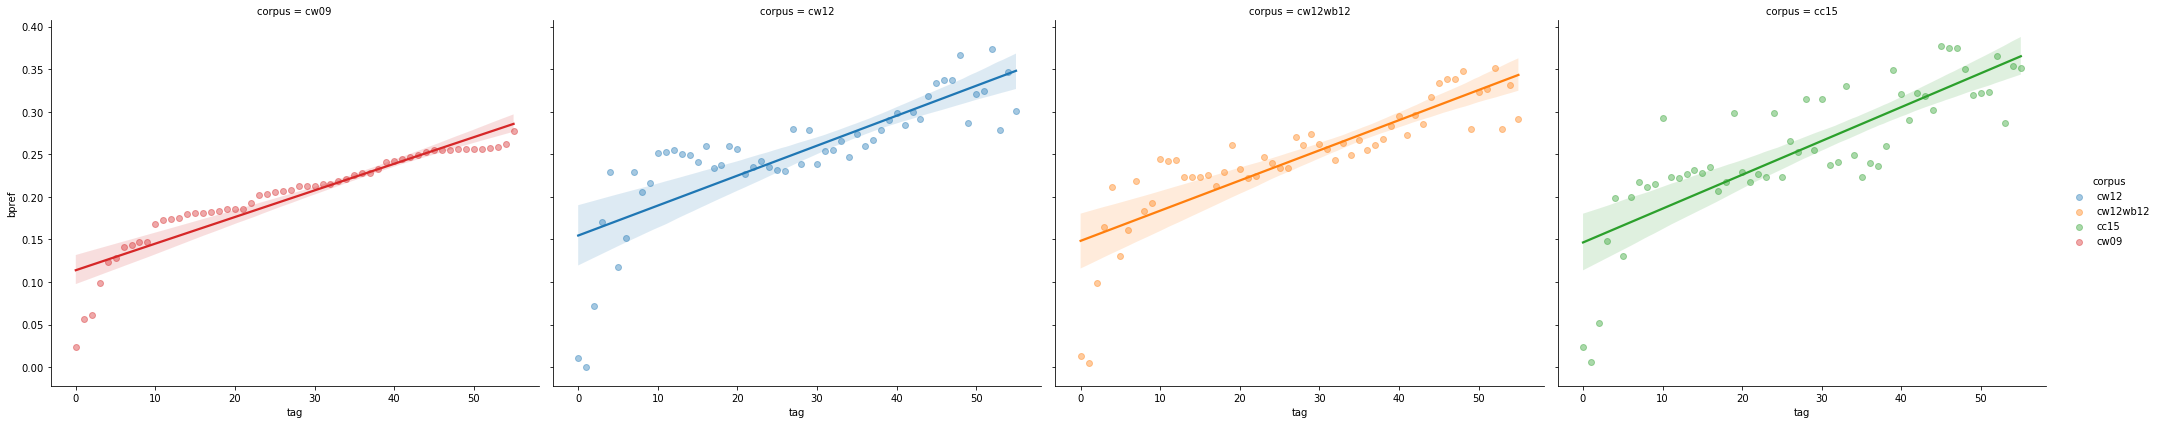

In [4]:
plot_correlations_per_corpus(df, 'bpref', '51-100')

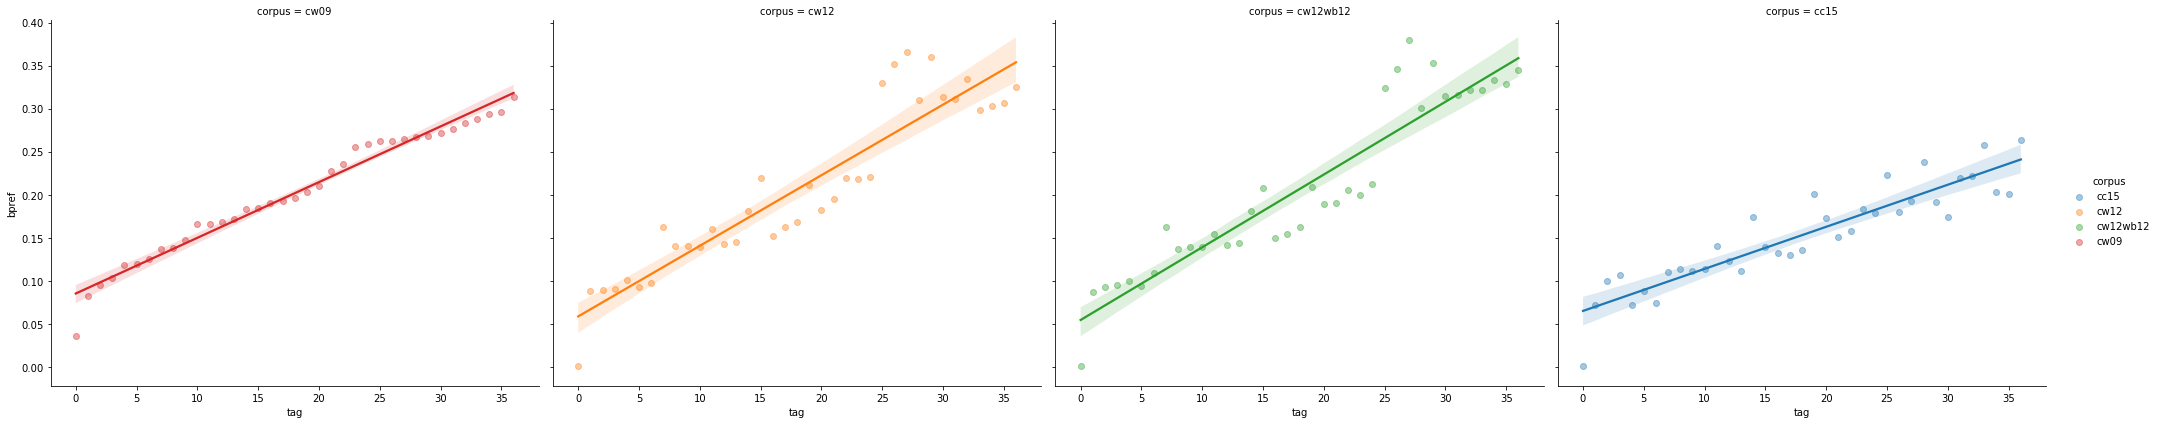

In [5]:
plot_correlations_per_corpus(df, 'bpref', '101-150')

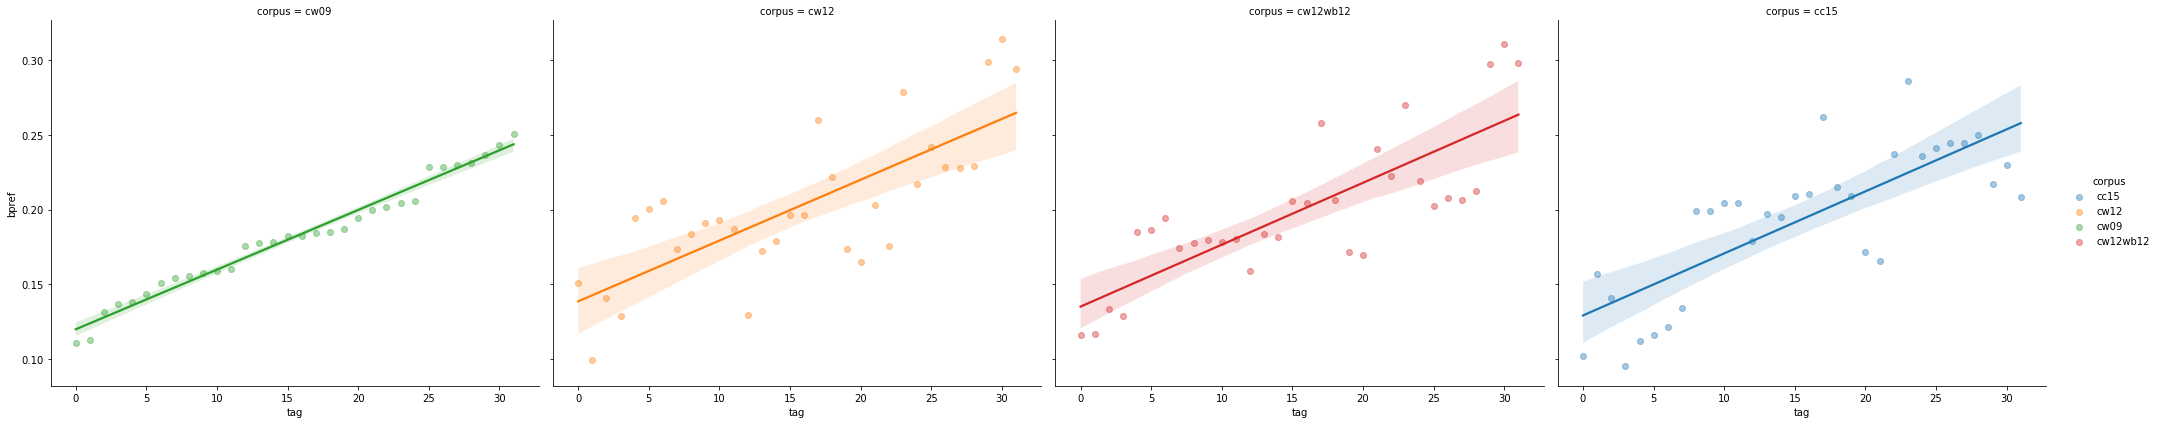

In [6]:
plot_correlations_per_corpus(df, 'bpref', '151-200')

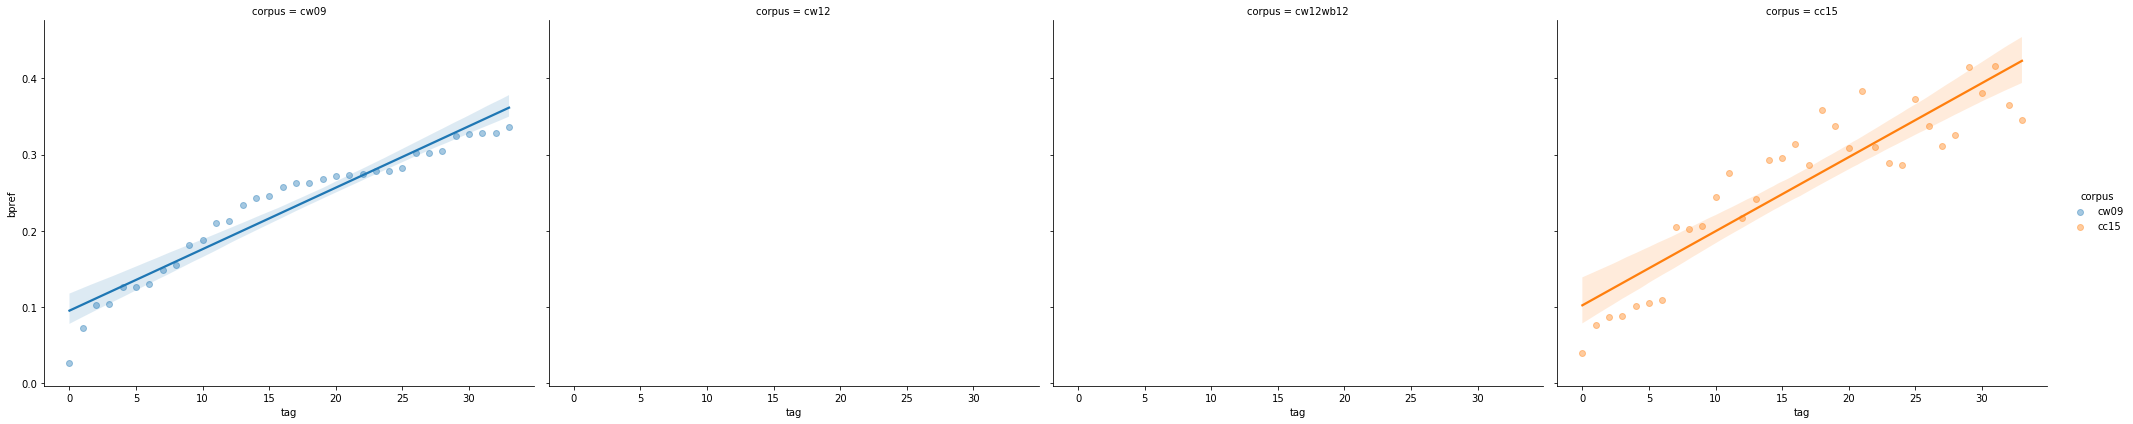

In [7]:
plot_correlations_per_corpus(df, 'bpref', '201-250')

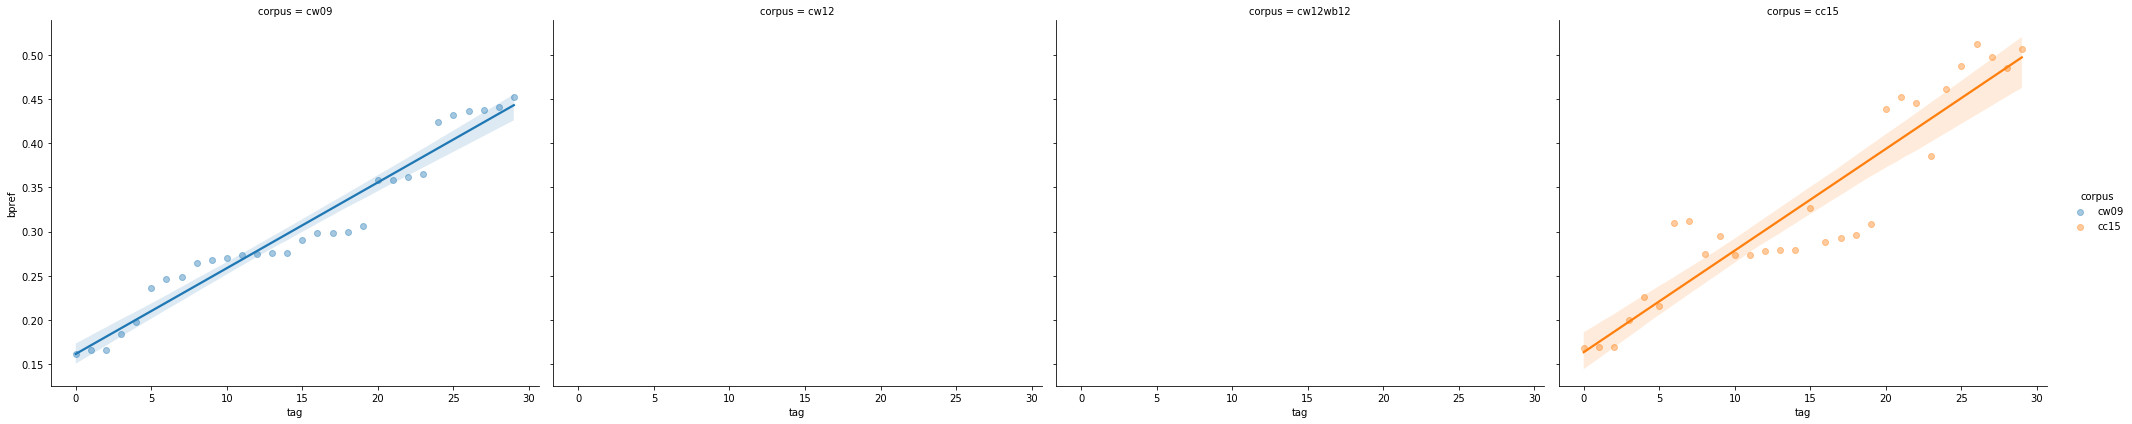

In [8]:
plot_correlations_per_corpus(df, 'bpref', '251-300')